<a href="https://colab.research.google.com/github/orin00/colab/blob/main/240424_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-g9gizzin
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-g9gizzin
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds # 텐서플로우 데이터셋 사용
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [6]:
# 데이터셋 받아오기
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteNPY9HO/cycle_gan-trainA.tfrecord*...…

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteNPY9HO/cycle_gan-trainB.tfrecord*...…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteNPY9HO/cycle_gan-testA.tfrecord*...:…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteNPY9HO/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


In [7]:
## 전처리 작업
BUFFER_SIZE = 1000 # 이미지 개수
BATCH_SIZE = 1 # 한 번에 모델이 학습하는 데이터 샘플의 개수
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [8]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size = [IMG_HEIGHT, IMG_WIDTH, 3]
  )
  return cropped_image

In [9]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image - 127.5) / 127.5 # =(image / 127.5) - 1
  return image

In [10]:
def random_jitter(image):
  # 286 * 286 * 3으로 이미지 사이즈 변경
  image = tf.image.resize(image, [286,286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # 256 * 256 * 3으로 랜덤하게 자르기
  image = random_crop(image)
  # 이미지 좌우 반전
  image = tf.image.random_flip_left_right(image)
  return image

In [11]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [12]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
# 트레인 데이터 나누기(= 데이터의 분산을 늘리기 위해서)

train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls = AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = test_zebras.cache().map(
    preprocess_image_train, num_parallel_calls = AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.cache().map(
    preprocess_image_train, num_parallel_calls = AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.cache().map(
    preprocess_image_train, num_parallel_calls = AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
sample_horses = next(iter(train_horses))
sample_zebras = next(iter(train_zebras))

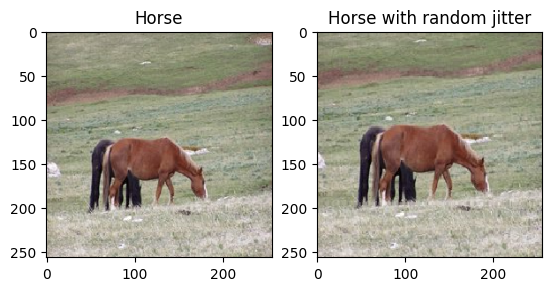

In [15]:
plt.subplot(1,2,1)
plt.title('Horse')
plt.imshow(sample_horses[0] * 0.5 + 0.5)

plt.subplot(1,2,2)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horses[0]) * 0.5 + 0.5)

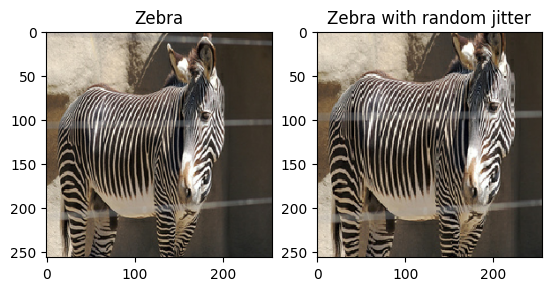

In [16]:
plt.subplot(1,2,1)
plt.title('Zebra')
plt.imshow(sample_zebras[0] * 0.5 + 0.5)

plt.subplot(1,2,2)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebras[0]) * 0.5 + 0.5)

In [17]:
from tensorflow_examples.models.pix2pix import pix2pix

OUTPUT_CHANNELS = 3
# pix2pix의 unet이라는 모델을 가져옴
# CycleGAN은 생성자 2개가 필요하다.

# generator_g : A를 입력받아 B로 만든다.
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# generator_f : B를 입력받아 A로 만든다.
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# discriminator_x : A감별자
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)

# discriminator_y : B감별자
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

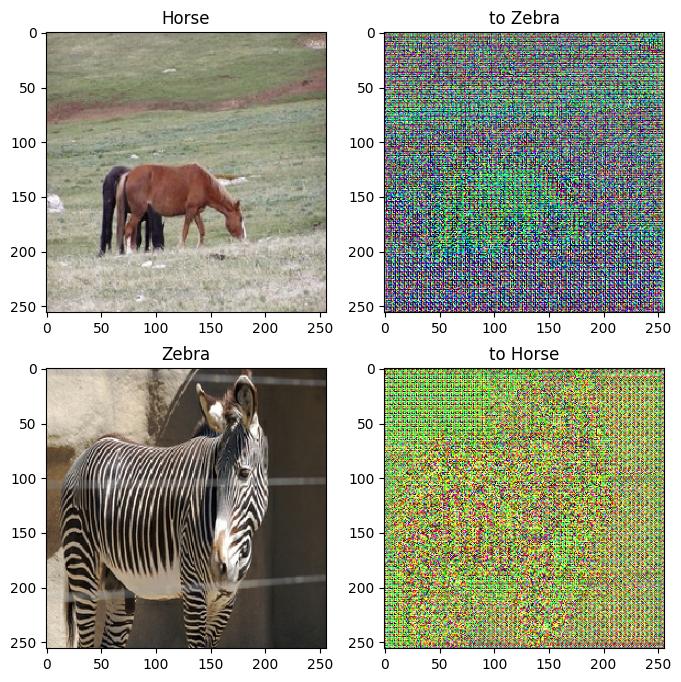

In [18]:
to_zebra = generator_g(sample_horses)
to_horse = generator_f(sample_zebras)
plt.figure(figsize=(8,8))
contrast = 8

imgs = [sample_horses, to_zebra, sample_zebras, to_horse]
title = ['Horse', 'to Zebra', 'Zebra', 'to Horse']

for i in range(len(imgs)):
  plt.subplot(2,2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)

plt.show()

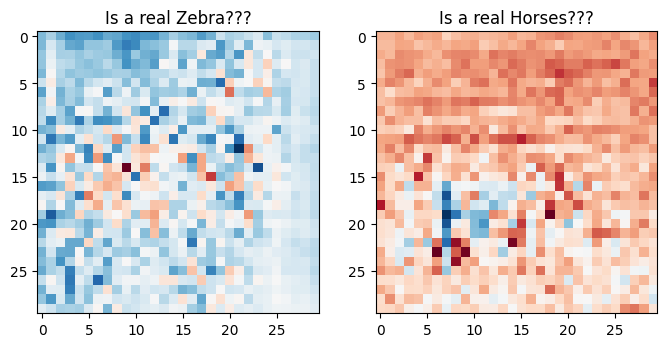

In [19]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.title('Is a real Zebra???')
plt.imshow(discriminator_y(sample_zebras)[0, ..., -1], cmap='RdBu_r')

plt.subplot(1,2,2)
plt.title('Is a real Horses???')
plt.imshow(discriminator_x(sample_horses)[0, ..., -1], cmap='RdBu_r')

In [20]:
LAMBDA = 10 # 손실값을 계산하기 위한 하나의 상수값 : 균형을 맞추기 위한 하이퍼파라미터
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True) # 손실함수

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss / 2

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [21]:
def calc_cycle_loss(real_image, cycled_image):
  # 실제 이미지와 사이클을 통해 생성된 이미지 간의 차이(절대값)의 평균
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))

  return LAMBDA * loss * 0.5

In [22]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [23]:
def generated_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12,12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input_Image', 'Predict_Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 * 0.5)
    plt.axis('off')

  plt.show()

In [27]:
# @ : 매직키, 파이썬 함수는 아니다, 외부에 대한 작업 명령어를 줄 때 사용함.
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    # 생성기 G : X -> Y
    # 생성기 F : Y -> X

    fake_y = generator_g(real_x, training = True)
    cycled_x = generator_f(fake_y, training = True)

    fake_x = generator_f(real_y, training = True)
    cycled_y = generator_g(fake_x, training = True)

    ## 손실 정의
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    ## Loss에 대한 적용(Grediant 계산)
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    ## 옵티마이저에 적용
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [28]:
EPOCHS = 20

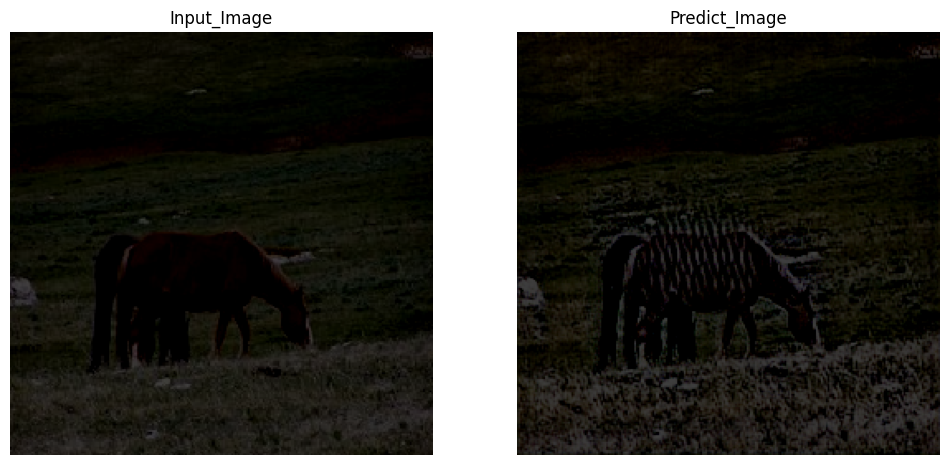

Time taken for epoch 20 is 65.3056206703186sec



In [29]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print('.', end='')
    n += 1
  clear_output(wait=True)
  generated_images(generator_g, sample_horses)

  print(f'Time taken for epoch {epoch+1} is {time.time() - start}sec\n')